In [1]:
from envs.KS_environment_jax import KSenv
from envs.KS_solver_jax import KS
from esn.esn import ESN
import jax
import jax.numpy as jnp
from functools import partial
from ddpg_experiment_v3 import draw_initial_condition, plot_KS_episode
from utils import covariance_matrix as cov
import ml_collections
from utils import preprocessing as pp
from utils.mode_decomposition import POD
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_episode(config, env, episode_type='null_action'):
    # create a action of zeros to pass
    null_action = jnp.zeros(env.action_size)

    # jit the necessary environment functions
    env_draw_initial_condition = partial(
        draw_initial_condition,
        std_init=config.enKF.std_init,
    )
    env_draw_initial_condition = jax.jit(env_draw_initial_condition)

    env_reset = partial(
        KSenv.reset,
        N=env.N,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        initial_amplitude=env.initial_amplitude,
        action_size=env.action_size,
        burn_in=env.burn_in,
        observation_inds=env.observation_inds,
    )

    env_reset = jax.jit(env_reset)
    env_step = partial(
        KSenv.step,
        frame_skip=env.frame_skip,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        target=env.target,
        actuator_loss_weight=env.actuator_loss_weight,
        termination_threshold=env.termination_threshold,
        observation_inds=env.observation_inds,
    )
    env_step = jax.jit(env_step)
    env_sample_action = partial(
        KSenv.sample_continuous_space,
        low=env.action_low,
        high=env.action_high,
        shape=(env.action_size,),
    )
    env_sample_action = jax.jit(env_sample_action)

    def until_first_observation(true_state, true_obs, observation_starts):
        def body_fun(carry, _):
            true_state, true_obs = carry
            # advance true environment
            action = null_action
            true_state, true_obs, reward, _, _, _ = env_step(
                state=true_state, action=action
            )
            return (true_state, true_obs), (true_state, true_obs, action, reward)

        (true_state, true_obs), (
            true_state_arr,
            true_obs_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun, (true_state, true_obs), jnp.arange(observation_starts)
        )
        return (
            true_state,
            true_obs,
            true_state_arr,
            true_obs_arr,
            action_arr,
            reward_arr,
        )
    
    def null_action_observe_and_forecast(
        true_state,
        true_obs,
        wait_steps,
        episode_steps,
        key_obs,
    ):
        def forecast_fun(carry, _):
            true_state, true_obs = carry

            # get action
            action = null_action

            # get the next observation and reward with this action
            true_state, true_obs, reward, _, _, _ = env_step(
                state=true_state, action=action
            )

            return (true_state, true_obs), (
                true_state,
                true_obs,
                action,
                reward,
            )

        def body_fun(carry, _):
            # observe
            # we got an observation
            # define observation covariance matrix
            true_state, true_obs, key_obs = carry

            obs_cov = cov.get_max(std=config.enKF.std_obs, y=true_obs)

            # add noise on the observation
            key_obs, _ = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(
                key_obs, true_obs, obs_cov, method="svd"
            )

            (true_state, true_obs), (
                true_state_arr,
                true_obs_arr,
                action_arr,
                reward_arr,
            ) = jax.lax.scan(
                forecast_fun, (true_state, true_obs), jnp.arange(wait_steps)
            )
            return (true_state, true_obs, key_obs), (
                true_state_arr,
                true_obs_arr,
                obs,
                action_arr,
                reward_arr,
            )

        n_loops = episode_steps // wait_steps
        (true_state, true_obs, key_obs), (
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun, (true_state, true_obs, key_obs), jnp.arange(n_loops)
        )
        return (
            true_state,
            true_obs,
            key_obs,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        )
    
    def random_observe_and_forecast(
        true_state,
        true_obs,
        wait_steps,
        episode_steps,
        key_obs,
        key_action,
    ):
        def forecast_fun(carry, _):
            true_state, true_obs, action = carry

            # get the next observation and reward with this action
            true_state, true_obs, reward, terminated, _, _ = env_step(
                state=true_state, action=action
            )

            return (true_state, true_obs, action), (
                true_state,
                true_obs,
                action,
                reward,
                terminated,
            )

        def body_fun(carry, _):
            # observe
            # we got an observation
            true_state, true_obs, key_obs, key_action = carry

            # get action
            key_action, _ = jax.random.split(key_action)
            action = env_sample_action(key=key_action)

            obs_cov = cov.get_max(std=config.enKF.std_obs, y=true_obs)

            # add noise on the observation
            key_obs, _ = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(
                key_obs, true_obs, obs_cov, method="svd"
            )

            # propagate environment with the given action
            (true_state, true_obs, action), (
                true_state_arr,
                true_obs_arr,
                action_arr,
                reward_arr,
                terminated_arr,
            ) = jax.lax.scan(
                forecast_fun,
                (true_state, true_obs, action),
                jnp.arange(wait_steps),
            )
            
            return (
                true_state,
                true_obs,
                key_obs,
                key_action,
            ), (true_state_arr, true_obs_arr, obs, action_arr, reward_arr)

        n_loops = episode_steps // wait_steps
        (true_state, true_obs, key_obs, key_action), (
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun,
            (true_state, true_obs, key_obs, key_action),
            jnp.arange(n_loops),
        )
        return (
            true_state,
            true_obs,
            key_obs,
            key_action,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        )

    until_first_observation = partial(
        until_first_observation,
        observation_starts=config.enKF.observation_starts,
    )
    until_first_observation = jax.jit(until_first_observation)

    null_action_observe_and_forecast = partial(
        null_action_observe_and_forecast,
        wait_steps=config.enKF.wait_steps,
        episode_steps=config.episode_steps - config.enKF.observation_starts,
    )
    null_action_observe_and_forecast = jax.jit(null_action_observe_and_forecast)

    random_observe_and_forecast = partial(
        random_observe_and_forecast,
        wait_steps=config.enKF.wait_steps,
        episode_steps=config.episode_steps - config.enKF.observation_starts,
    )
    random_observe_and_forecast = jax.jit(random_observe_and_forecast)
    def episode(key_env, key_obs, key_action):
        # reset the environment
        key_env, key_init = jax.random.split(key_env, 2)
        init_true_state_mean, _, _ = env_reset(key=key_env)
        init_true_state = env_draw_initial_condition(u0=init_true_state_mean, key=key_init)
        init_true_obs = init_true_state[env.observation_inds]

        init_reward = jnp.nan

        # forecast until first observation
        (
            true_state,
            true_obs,
            true_state_arr0,
            true_obs_arr0,
            action_arr0,
            reward_arr0,
        ) = until_first_observation(
            true_state=init_true_state, true_obs=init_true_obs
        )

        if episode_type == 'null_action':
            (
            true_state,
            true_obs,
            key_obs,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
            ) = null_action_observe_and_forecast(
                true_state=true_state,
                true_obs=true_obs,
                key_obs=key_obs,
            ) 
        elif episode_type == 'random_action':
            # add noise on the observation
            (
                true_state,
                true_obs,
                key_obs,
                key_action,
                true_state_arr,
                true_obs_arr,
                obs_arr,
                action_arr,
                reward_arr,
            ) = random_observe_and_forecast(
                true_state=true_state,
                true_obs=true_obs,
                key_obs=key_obs,
                key_action=key_action,
            )

        true_state_arr = jnp.reshape(
            true_state_arr,
            (
                true_state_arr.shape[0] * true_state_arr.shape[1],
                true_state_arr.shape[2],
            ),
        )
        true_obs_arr = jnp.reshape(
            true_obs_arr,
            (true_obs_arr.shape[0] * true_obs_arr.shape[1], true_obs_arr.shape[2]),
        )
        action_arr = jnp.reshape(
            action_arr,
            (action_arr.shape[0] * action_arr.shape[1], action_arr.shape[2]),
        )

        reward_arr = jnp.reshape(
            reward_arr,
            (reward_arr.shape[0] * reward_arr.shape[1],),
        )
        stack = lambda a, b, c: jnp.vstack((jnp.expand_dims(a, axis=0), b, c))
        hstack = lambda a, b, c: jnp.hstack((jnp.expand_dims(a, axis=0), b, c))

        return (
            stack(init_true_state, true_state_arr0, true_state_arr),
            stack(init_true_obs, true_obs_arr0, true_obs_arr),
            obs_arr,
            stack(null_action, action_arr0, action_arr),
            hstack(init_reward, reward_arr0, reward_arr),
            key_env,
            key_obs,
            key_action,
        )
    
    return episode       

In [72]:
config = ml_collections.ConfigDict()
config.env = ml_collections.ConfigDict()
config.env.N = 64
L = 22
nu = (2 * jnp.pi / L)**2
config.env.nu = nu
config.env.actuator_scale = 0.1
config.env.actuator_loss_weight = 1.0
config.env.burn_in = 1000
config.env.actuator_locs = ((2 * jnp.pi) / 2) * jnp.arange(2)
config.env.sensor_locs = ((2 * jnp.pi) / 8) * jnp.arange(8)
config.env.target = "e0"
config.env.frame_skip = 1

config.seed = 41
config.episode_steps = 1000

config.enKF = ml_collections.ConfigDict()
config.enKF.std_init = 0.0
config.enKF.m = 0
config.enKF.std_obs = 0.0
config.enKF.low_order_N = 0
config.enKF.observation_starts = 0
config.enKF.wait_steps = 1

In [73]:
# create environment
env = KSenv(**config.env)

In [78]:
seed = 0
key = jax.random.PRNGKey(seed)
key, key_env, key_obs, key_action = jax.random.split(key, 4) 
episode = generate_episode(config, env, episode_type='random_action')

In [79]:
total_episodes = 210

RAW_DATA = {'true_state':[],'true_observation':[],'observation':[],'action':[],'pod_time_coeff':[]}
# for i in range(total_episodes):
#     (
#         true_state_arr,
#         true_obs_arr,
#         obs_arr,
#         action_arr,
#         reward_arr,
#         key_env,
#         key_obs,
#         key_action
#     ) =  episode(key_env, key_obs, key_action)
#     # fig = plot_KS_episode(
#     #     env,
#     #     true_state_arr,
#     #     true_obs_arr,
#     #     obs_arr,
#     #     action_arr,
#     #     reward_arr,
#     #     config.enKF.wait_steps,
#     #     config.enKF.observation_starts,
#     # )
#     RAW_DATA['true_state'].append(true_state_arr)
#     RAW_DATA['true_observation'].append(true_obs_arr)
#     RAW_DATA['observation'].append(obs_arr)
#     RAW_DATA['action'].append(action_arr)


# Define batched random keys for parallel processing
key_env, subkey_env = jax.random.split(key_env)
key_obs, subkey_obs = jax.random.split(key_obs)
key_action, subkey_action = jax.random.split(key_action)

# Create batched keys for all episodes
batch_keys_env = jax.random.split(subkey_env, total_episodes)
batch_keys_obs = jax.random.split(subkey_obs, total_episodes)
batch_keys_action = jax.random.split(subkey_action, total_episodes)

# Use vmap to process all episodes in parallel
batched_results = jax.vmap(episode)(
    batch_keys_env,
    batch_keys_obs,
    batch_keys_action
)

# Unpack results
(
    true_state_arrs,
    true_obs_arrs,
    obs_arrs,
    action_arrs,
    reward_arrs,
    _, _, _  # Keys can be ignored if not needed further
) = batched_results

RAW_DATA['true_state'] = true_state_arrs
RAW_DATA['true_observation'] = true_obs_arrs
RAW_DATA['observation'] = obs_arrs
RAW_DATA['action'] = action_arrs

In [80]:
pod_episodes = 200
def get_POD_time_coeffs(my_POD,y):
    return (y-my_POD.Q_mean) @ my_POD.Phi

# apply POD
stacked_state_arr = jnp.vstack(RAW_DATA['true_state'][:pod_episodes])
my_POD = POD(X=stacked_state_arr.T)

for i in range(total_episodes):
    RAW_DATA['pod_time_coeff'].append(get_POD_time_coeffs(my_POD, RAW_DATA['true_state'][i]))

Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.


c:\Users\egeoz\Imperial\DA-RL\utils\mode_decomposition.py:221: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


Returning temporal coefficients for classic POD.


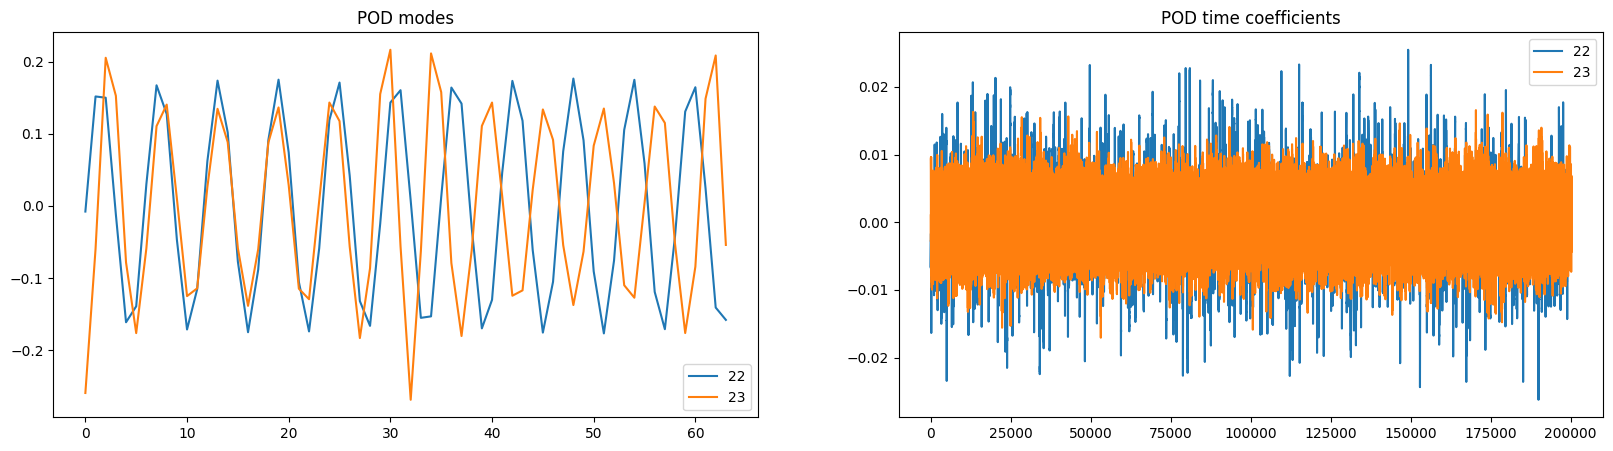

In [81]:
pod_modes = my_POD.get_modes[0]
which_mode = [22,23]
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pod_modes[:,which_mode])
plt.title('POD modes')
plt.legend(which_mode)
plt.subplot(1,2,2)
plt.plot(my_POD.get_time_coefficient[:,which_mode])
plt.title('POD time coefficients')
plt.legend(which_mode)

In [86]:
which_state = 'true_state'
which_modes = 16

train_episodes = 45
val_episodes = 5
test_episodes = 5

train_idxs = np.arange(train_episodes)
val_idxs = np.arange(train_episodes, train_episodes+val_episodes)
test_idxs = np.arange(pod_episodes, pod_episodes+test_episodes) 
idxs_list = np.concatenate((train_idxs,val_idxs,test_idxs), axis=None)

total_time = env.dt * config.episode_steps
washout_time = 5
train_time = total_time - washout_time
# validation_time = 0.2 * total_time
network_dt = env.dt
t = env.dt * jnp.arange(config.episode_steps+1)

loop_names=['train']
loop_times = [train_time]
DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'full_state':[],'t':[]}

for i in idxs_list:
    if which_state == 'pod_time_coeff':
        y = RAW_DATA[which_state][i][:,:which_modes] 
    else:
        y = RAW_DATA[which_state][i]

    full_state = RAW_DATA['true_state'][i]

    episode_data = pp.create_dataset(full_state,y,t,RAW_DATA['action'][i][1:],
                                    network_dt,
                                    transient_time=0,
                                    washout_time=washout_time,
                                    loop_times=loop_times,
                                    loop_names=loop_names,
                                    )
    for loop_name in loop_names:
        [DATA[loop_name][var].append(episode_data[loop_name][var]) for var in DATA[loop_name].keys()]

# new idxs
train_idxs = np.arange(train_episodes)
val_idxs = np.arange(train_episodes, train_episodes+val_episodes)
test_idxs = np.arange(train_episodes+val_episodes, train_episodes+val_episodes+test_episodes) 

In [87]:
data_mean = np.mean(np.vstack(DATA["train"]["u"]), axis = 0)
data_std = np.std(np.vstack(DATA["train"]["u"]), axis = 0)

In [88]:
ESN_dict = {
        "reservoir_size": 3000,
        "parameter_dimension": env.action_size,
        "reservoir_connectivity": 3,
        "r2_mode": True,
        "input_only_mode": False,
        "input_weights_mode": 'sparse_grouped',
        "reservoir_weights_mode": 'erdos_renyi1',
        "tikhonov": 1e-5,
        "dimension": DATA['train']['u'][0].shape[1],
        # "output_bias": np.array([1.0]),
        # "input_bias": np.array([0.01]),
        # "input_normalization": [data_mean, data_std],
        "spectral_radius": 0.54523636,
        "input_scaling": 0.0279345,
        "leak_factor": 1.0
    }

ESN_dict['input_seeds'] = [0,1,2]
ESN_dict['reservoir_seeds'] = [3,4]

my_ESN = ESN(**ESN_dict)
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             DATA["train"]["p_washout"], 
             DATA["train"]["p"],
             train_idx_list=train_idxs 
            )

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [89]:
from esn.validation import validate
from esn.utils import errors,scalers

# hyperparameter names, should match the attributes of ESN
hyp_param_names = ['input_scaling','spectral_radius','leak_factor','tikhonov','parameter_normalization_var']

# range for hyperparameters 
spec_in     = 0.1
spec_end    = 1.25
in_scal_in  = 0.01
in_scal_end = 10.0
leak_in     = 0.1    
leak_end    = 1.0
tikh_in = 1e-8
tikh_end = 1e-1
param_var_in = 0.01 
param_var_end = 10.0
grid_range = [[in_scal_in, in_scal_end],
              [spec_in, spec_end],
              [leak_in, leak_end],
              [tikh_in, tikh_end],
              [param_var_in, param_var_end],
              ]

# scales, uniform or log10
hyp_param_scales = ['log10','log10','uniform','log10','log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])
        
N_washout = int(np.round(washout_time/network_dt))
fold_time = 25
N_val = int(np.round(fold_time/network_dt))
N_transient = 0
min_dict = validate(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 10, n_initial_points = 5,
    ESN_dict = ESN_dict,
    U_washout_train = DATA["train"]["u_washout"],
    U_train = DATA["train"]["u"],
    U_val = DATA["train"]["u"],
    Y_train = DATA["train"]["y"],
    Y_val = DATA["train"]["y"],
    P_washout_train = DATA["train"]["p_washout"],
    P_train = DATA["train"]["p"],
    P_val = DATA["train"]["p"],
    n_folds = 3,
    n_realisations= 1,
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    N_transient_steps = N_transient,
    n_grid = None,
    error_measure=errors.rel_L2,
    train_idx_list=train_idxs,
    val_idx_list=val_idxs)

--NEW RUN-- 1
Realisation: 0
input_scaling 0.07875596470213515
spectral_radius 0.3487551633033622
leak_factor 0.49871345291974767
tikhonov 0.01
parameter_normalization_var 0.562296280607296


Val regime: 0
Val regime error: 0.24858739704234611
Val regime: 1
Val regime error: 0.12997769863613626
Val regime: 2
Val regime error: 0.24738796831743123
Val regime: 3
Val regime error: 0.24021765258022632
Val regime: 4
Val regime error: 0.26389326246923767
Realisation error: 0.22601279580907555


Run 1 error: 0.22601279580907555
Error: 0.22601279580907555


--NEW RUN-- 2
Realisation: 0
input_scaling 0.011899129341402899
spectral_radius 0.5997045823533774
leak_factor 0.33900951409488733
tikhonov 1e-06
parameter_normalization_var 0.02825749124952495


Val regime: 0
Val regime error: 43.198334921798214
Val regime: 1
Val regime error: 51.5886621212202
Val regime: 2
Val regime error: 47.06022370078805
Val regime: 3
Val regime error: 42.710760474437585
Val regime: 4
Val regime error: 42.5727792740259

In [90]:
best_idx = 0
ESN_dict['spectral_radius'] = min_dict["spectral_radius"][best_idx]
ESN_dict['input_scaling'] = min_dict["input_scaling"][best_idx]
ESN_dict['leak_factor'] = min_dict["leak_factor"][best_idx]
ESN_dict['tikhonov'] = min_dict["tikhonov"][best_idx]

my_ESN = ESN(**ESN_dict)
my_ESN.parameter_normalization_var = min_dict["parameter_normalization_var"][best_idx]
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             DATA["train"]["p_washout"], 
             DATA["train"]["p"],
             train_idx_list=train_idxs 
            )

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Parameter normalization is changed, training must be done again.


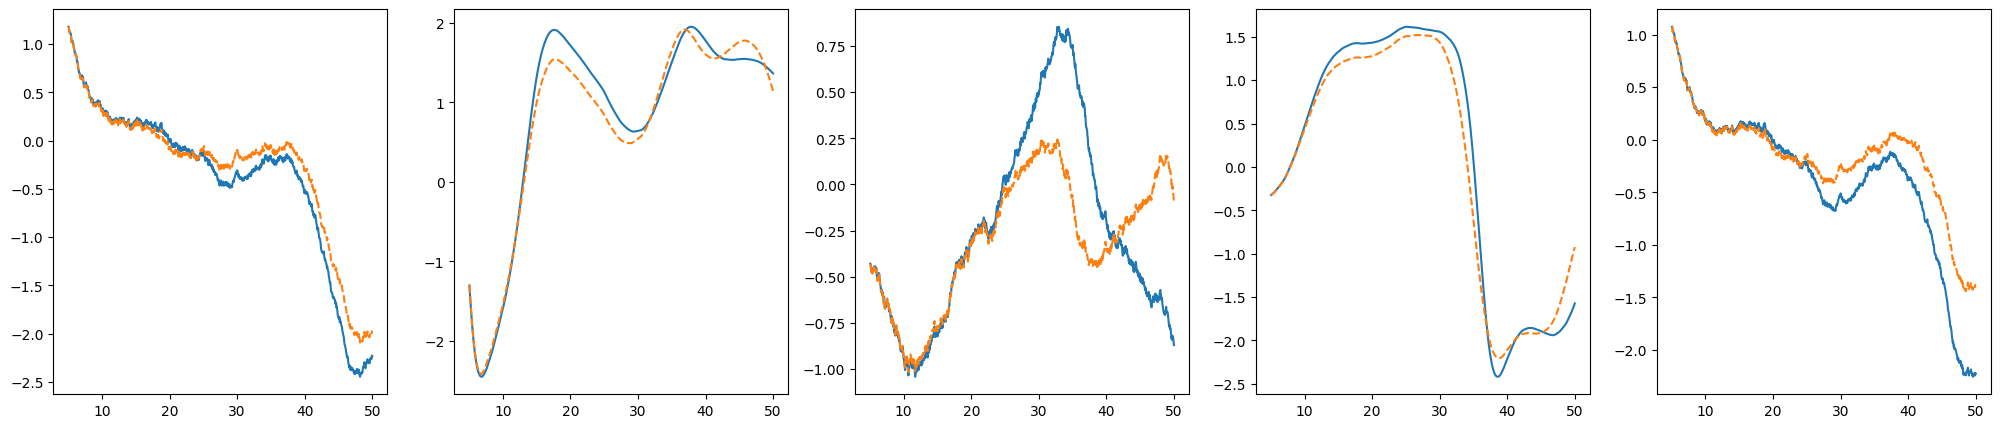

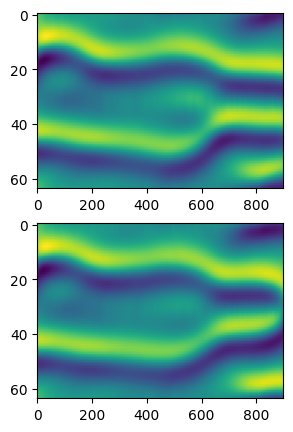

In [91]:
episode_idx = train_idxs[0]
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=DATA['train']['u_washout'][episode_idx], 
                                                 P_washout=DATA['train']['p_washout'][episode_idx],
                                                 P = DATA['train']['p'][episode_idx],
                                                 N_t=len(DATA['train']['u'][episode_idx]))
y_pred = y_pred[1:]
plt_idxs = [int(my_idx) for my_idx in np.linspace(0,my_ESN.N_dim-1,5)]
plt.figure(figsize=(5*len(plt_idxs),5))
for k, plt_idx in enumerate(plt_idxs):
    plt.subplot(1,len(plt_idxs),k+1)
    plt.plot(DATA['train']['t'][episode_idx],DATA['train']['y'][episode_idx][:,plt_idx])
    plt.plot(DATA['train']['t'][episode_idx],y_pred[:,plt_idx],'--')
    # plt.xlim([0,500])
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.imshow(DATA['train']['y'][episode_idx].T, aspect=10)
plt.subplot(2,1,2)
plt.imshow(y_pred.T, aspect=10)

if which_state == 'pod_time_coeff':
    recon_y = my_POD.reconstruct(which_modes=which_modes,
                        A=DATA['train']['y'][episode_idx],
                    )
    recon_y_pred = my_POD.reconstruct(which_modes=which_modes,
                        A=y_pred,
                    )

    plt.figure(figsize=(20,10), constrained_layout=True)
    plt.subplot(5,1,1)
    plt.imshow(DATA['train']['full_state'][episode_idx].T, aspect=10)
    plt.title(f'True')
    plt.colorbar()
    plt.subplot(5,1,2)
    plt.imshow(recon_y, aspect=10)
    plt.title(f'True Reduced N = {which_modes}')
    plt.colorbar()
    plt.subplot(5,1,3)
    plt.imshow(recon_y_pred, aspect=10)
    plt.title(f'Prediction Reduced N = {which_modes}')
    plt.colorbar()
    plt.subplot(5,1,4)
    plt.imshow(DATA['train']['full_state'][episode_idx].T-recon_y_pred, aspect=10)
    plt.title('Error')
    plt.colorbar()
    plt.subplot(5,1,5)
    plt.imshow(recon_y-recon_y_pred, aspect=10)
    plt.title('Error Reduced')
    plt.colorbar()
    plt.show()

In [92]:
seed = 1
key = jax.random.PRNGKey(seed)
key, key_env, key_obs, key_action = jax.random.split(key, 4) 
config.episode_steps = 20000

total_time = env.dt * config.episode_steps
loop_time = total_time-washout_time
network_dt = env.dt
t = env.dt * jnp.arange(config.episode_steps+1)

loop_times = [loop_time]

episode = generate_episode(config, env, episode_type='null_action')
(
    true_state_arr,
    true_obs_arr,
    obs_arr,
    action_arr,
    reward_arr,
    _, _, _  # Keys can be ignored if not needed further
) = episode(key_env, key_obs, key_action)

RAW_EPISODE_DATA = {
    'true_state': true_state_arr,
    'true_observation': true_obs_arr,
    'observation': obs_arr,
    'action': action_arr
}
RAW_EPISODE_DATA['pod_time_coeff'] = get_POD_time_coeffs(my_POD, true_state_arr)
if which_state == 'pod_time_coeff':
    y = RAW_EPISODE_DATA[which_state][:,:which_modes] 
else:
    y = RAW_EPISODE_DATA[which_state]

full_state = RAW_EPISODE_DATA['true_state']
EPISODE_DATA = pp.create_dataset(full_state,y,t,RAW_EPISODE_DATA['action'][1:],
                                network_dt,
                                transient_time=0,
                                washout_time=washout_time,
                                loop_times=loop_times,
                                loop_names=None,
                                )


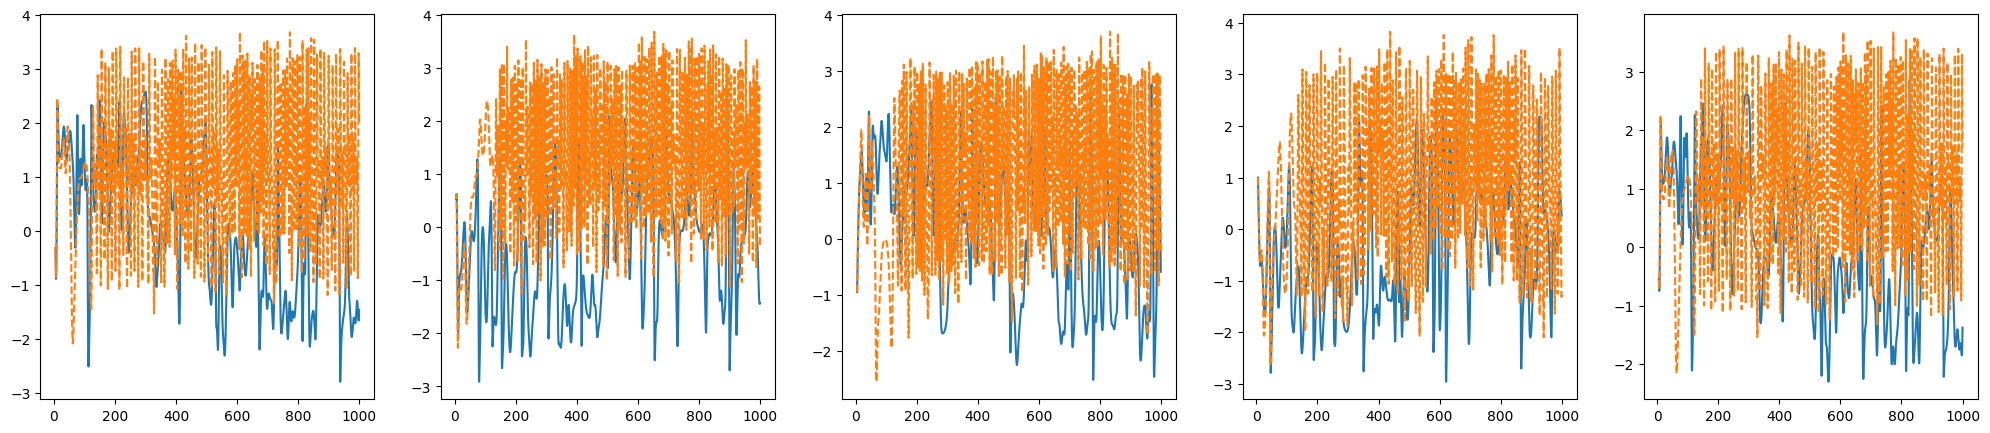

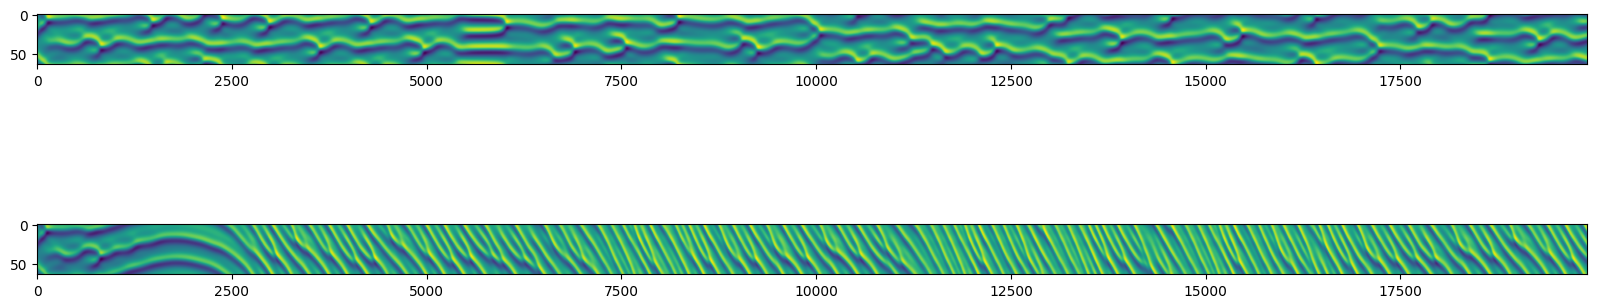

In [93]:
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=EPISODE_DATA['loop_0']['u_washout'], 
                                                 P_washout=EPISODE_DATA['loop_0']['p_washout'],
                                                 P = EPISODE_DATA['loop_0']['p'],
                                                 N_t=len(EPISODE_DATA['loop_0']['u']))
y_pred = y_pred[1:]
plt_idxs = [int(my_idx) for my_idx in np.linspace(0,my_ESN.N_dim-1,5)]
plt.figure(figsize=(5*len(plt_idxs),5))
for k, plt_idx in enumerate(plt_idxs):
    plt.subplot(1,len(plt_idxs),k+1)
    plt.plot(EPISODE_DATA['loop_0']['t'],EPISODE_DATA['loop_0']['y'][:,plt_idx])
    plt.plot(EPISODE_DATA['loop_0']['t'],y_pred[:,plt_idx],'--')
    # plt.xlim([0,500])
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.imshow(EPISODE_DATA['loop_0']['y'].T, aspect=10)
plt.subplot(2,1,2)
plt.imshow(y_pred.T, aspect=10)

if which_state == 'pod_time_coeff':
    recon_y = my_POD.reconstruct(which_modes=which_modes,
                        A=EPISODE_DATA['loop_0']['y'],
                    )
    recon_y_pred = my_POD.reconstruct(which_modes=which_modes,
                        A=y_pred,
                    )

    plt.figure(figsize=(20,10), constrained_layout=True)
    plt.subplot(5,1,1)
    plt.imshow(EPISODE_DATA['loop_0']['full_state'].T, aspect=10)
    plt.title(f'True')
    plt.colorbar()
    plt.subplot(5,1,2)
    plt.imshow(recon_y, aspect=10)
    plt.title(f'True Reduced N = {which_modes}')
    plt.colorbar()
    plt.subplot(5,1,3)
    plt.imshow(recon_y_pred, aspect=10)
    plt.title(f'Prediction Reduced N = {which_modes}')
    plt.colorbar()
    plt.subplot(5,1,4)
    plt.imshow(EPISODE_DATA['loop_0']['full_state'].T-recon_y_pred, aspect=10)
    plt.title('Error')
    plt.colorbar()
    plt.subplot(5,1,5)
    plt.imshow(recon_y-recon_y_pred, aspect=10)
    plt.title('Error Reduced')
    plt.colorbar()
    plt.show()